<a href="https://colab.research.google.com/github/sugitora/-AutoSendGmail/blob/master/%F0%9F%96%A5_20240501_EDA_on_2023_YouTube_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'global-youtube-statistics-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3566603%2F6211042%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T123322Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D478755d3fde7aafa95b88343f41f0076abd698c35edcebe1f3e176d2994bce1f52c52f63041b7e96785c61df1ec570627b591eef1b2f1b966b64278335bd390ad4e2bbb787877e3e97595c7d23f2bf61f0d4ff5a61c2c67c0d82e24ba04d3117d7257cd54b9991b5dbef82ac7dbbbeadbb56ea288f2220870f36775979a1779870a04230152cb615a8b8b5c7e0c964f0f15cbd89ecb898c09eaea0940b368de71c7c3e3ce559235df63f909cc807bda19ac985f9403402cd0750d8517e6a6a55d4ad65e311a827cf068b9389b223ac52ca6b92acf02430277a38a8450c47a09d716b501b57f2ac9aa7a549caca891a44b7a5d53ae242b8a0f17112b083342b71'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 61533 bytes downloaded
Downloaded and uncompressed: global-youtube-statistics-2023
Data source import complete.


# <div style="text-align: center; background-color: #FF0000; font-family:Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">🖥 EDA on 2023 YouTube Statistics</div>

![image](https://static.vecteezy.com/system/resources/previews/003/206/623/original/youtube-editorial-app-icon-free-vector.jpg)

## <div style="text-align: left; background-color: #FF5252; font-family: Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">🙇‍♀️ Goal of the Project<div>
The project is to analyze and visualize trends and tap into opportuties for billion-dollar success. I will mainly analyze the following criteria of the dataset: <br>
    <li> Earning 💵 </li>
    <li>Channel Type 🖥️ </li>
    <li>Geogaphical Distribution 🗺️ </li>

## <div style="text-align: left; background-color: #FF5252; font-family: Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">🙇‍♀️ プロジェクトの目的<div>
このプロジェクトは、数十億ドル規模の成功につながる機会を探り、トレンドを分析し可視化することである。主に以下の基準を分析することになる。<br>
    <li> 収益 💵 </li>
    <li> チャンネルタイプ 🖥️ </li>
    <li> 地理的分布 🗺️ </li>

<a id="1"></a>
# <div style="text-align: center; background-color: #FF4500; font-family: Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">1. Loading necessary libraries and dataset</div>

In [ ]:
## Remove Warnings ##
import warnings
warnings.filterwarnings("ignore")

## Data ##
import pandas as pd
import numpy as np

## Image Request ##
import requests
from io import BytesIO

## Visualization ##
import missingno as msno
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [ ]:
df = pd.read_csv('/kaggle/input/global-youtube-statistics-2023/Global YouTube Statistics.csv', encoding = 'ISO-8859-1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   rank                                     995 non-null    int64  
 1   Youtuber                                 995 non-null    object 
 2   subscribers                              995 non-null    int64  
 3   video views                              995 non-null    float64
 4   category                                 949 non-null    object 
 5   Title                                    995 non-null    object 
 6   uploads                                  995 non-null    int64  
 7   Country                                  873 non-null    object 
 8   Abbreviation                             873 non-null    object 
 9   channel_type                             965 non-null    object 
 10  video_views_rank                         994 non-n

There are <b>20</b> float types, <b>3</b> integer types, and <b>8</b> object types.

In [ ]:
df.describe()

,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,...,highest_yearly_earnings,subscribers_for_last_30_days,created_year,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
count,995.00000,9.950000e+02,9.950000e+02,995.000000,9.940000e+02,879.000000,962.000000,9.390000e+02,995.000000,9.950000e+02,...,9.950000e+02,6.580000e+02,990.000000,990.000000,872.000000,8.720000e+02,872.000000,8.720000e+02,872.000000,872.000000
mean,498.00000,2.298241e+07,1.103954e+10,9187.125628,5.542489e+05,386.053470,745.719335,1.756103e+08,36886.148281,5.898078e+05,...,7.081814e+06,3.490791e+05,2012.630303,15.746465,63.627752,4.303873e+08,9.279278,2.242150e+08,26.632783,-14.128146
std,287.37606,1.752611e+07,1.411084e+10,34151.352254,1.362782e+06,1232.244746,1944.386561,4.163782e+08,71858.724092,1.148622e+06,...,1.379704e+07,6.143554e+05,4.512503,8.777520,26.106893,4.727947e+08,4.888354,1.546874e+08,20.560533,84.760809
min,1.00000,1.230000e+07,0.000000e+00,0.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,1.000000e+00,1970.000000,1.000000,7.600000,2.025060e+05,0.750000,3.558800e+04,-38.416097,-172.104629
25%,249.50000,1.450000e+07,4.288145e+09,194.500000,3.230000e+02,11.000000,27.000000,2.013750e+07,2700.000000,4.350000e+04,...,5.217500e+05,1.000000e+05,2009.000000,8.000000,36.300000,8.335541e+07,5.270000,5.590832e+07,20.593684,-95.712891
50%,498.00000,1.770000e+07,7.760820e+09,729.000000,9.155000e+02,51.000000,65.500000,6.408500e+07,13300.000000,2.127000e+05,...,2.600000e+06,2.000000e+05,2013.000000,16.000000,68.000000,3.282395e+08,9.365000,2.706630e+08,37.090240,-51.925280
75%,746.50000,2.460000e+07,1.355470e+10,2667.500000,3.584500e+03,123.000000,139.750000,1.688265e+08,37900.000000,6.068000e+05,...,7.300000e+06,4.000000e+05,2016.000000,23.000000,88.200000,3.282395e+08,14.700000,2.706630e+08,37.090240,78.962880
max,995.00000,2.450000e+08,2.280000e+11,301308.000000,4.057944e+06,7741.000000,7741.000000,6.589000e+09,850900.000000,1.360000e+07,...,1.634000e+08,8.000000e+06,2022.000000,31.000000,113.100000,1.397715e+09,14.720000,8.429340e+08,61.924110,138.252924


<Axes: >

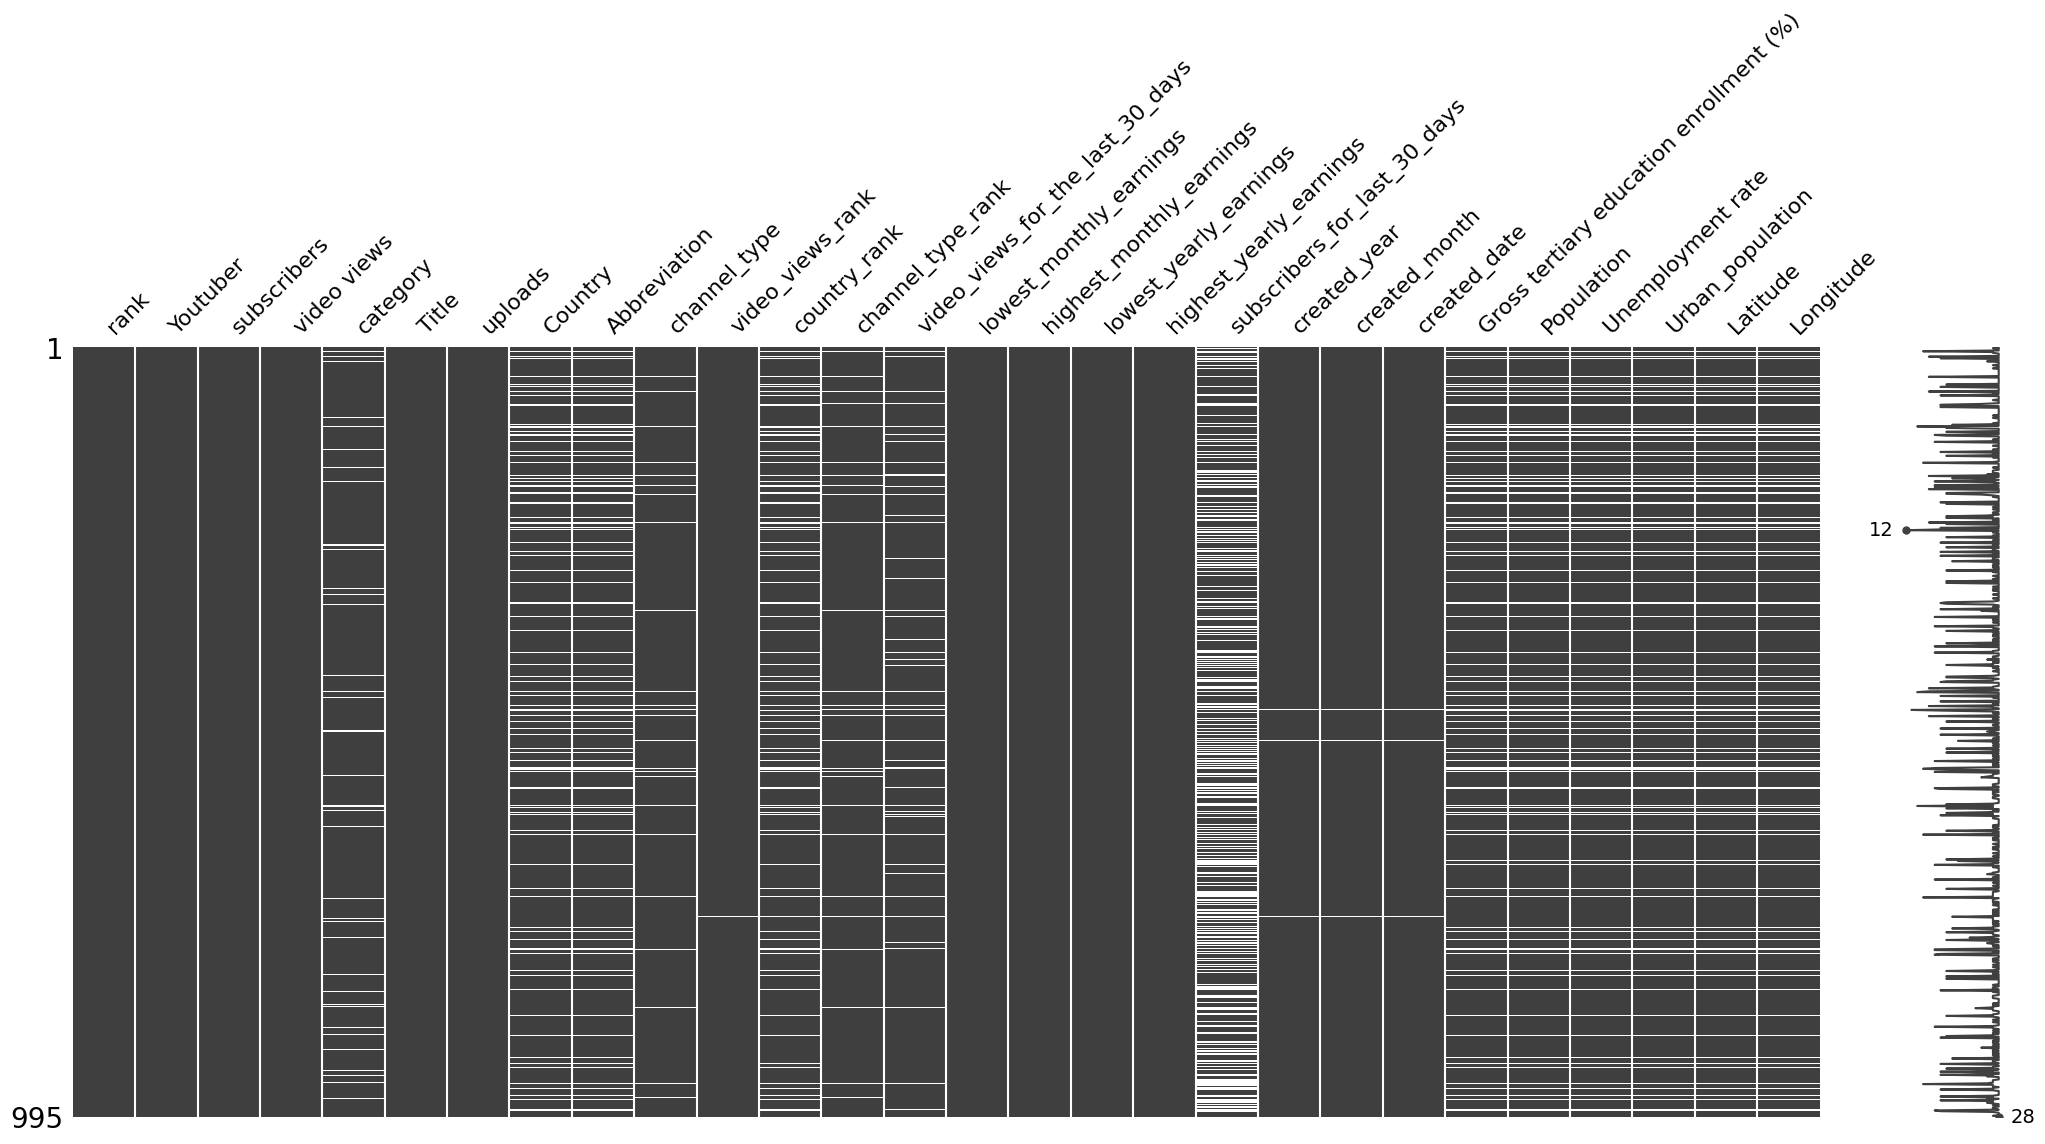

In [ ]:
msno.matrix(df)

In [ ]:
df['created_year'].min()

1970.0

As there are many <mark>missing values</mark>, I will remove the data with null values. Moreover, there is <mark>a wrong data value</mark>, which has created year equals to 1970 (YouTube was created in 2005, there is no way that the channel was created before that).

欠損値が多いため、null値を持つデータを削除することにする。さらに、誤ったデータ値が存在する。それはチャンネルの作成年が1970年とされているものである（YouTubeが2005年に創設されたため、それ以前にチャンネルが作成されたことはあり得ない）。

In [ ]:
df = df.dropna()
df.drop(df.loc[df['created_year'] == 1970].index, inplace=True)

In [ ]:
color_scheme = px.colors.sequential.Reds

<!-- ![Screenshot 2023-09-11 at 9.26.10 PM.png](attachment:cb766328-8ce2-49e3-9a25-fb376841acba.png) -->

<a id="2"></a>
# <div style="text-align: center; background-color: #FF4500; font-family: Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">2. Univariate Analysis </div>

<a id="2.1"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.1. YouTube Channel Started Date Trend</div>

In [ ]:
year_counts = df['created_year'].value_counts().sort_index()

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=year_counts.index,
        y=year_counts.values,
        fill='tozeroy',
        line_color='darkred',
        mode='lines+markers'
    )
)

fig.update_layout(
    title_text='YouTube Channels Created Year',
    template='plotly_white',
    xaxis=dict(
        title='Year',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Number of Channels',
        titlefont_size=16
    ),
)

fig.show()

YouTubers who have more than <mark>12 million subscribers</mark> created their YouTube in <b>2014</b>.

YouTubeで12百万人以上の登録者を持つユーチューバーは、そのチャンネルを<b>2014年</b>に作成した。

<a id="2.2"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.2. Top 100 Most Subscribed YouTube Channel Names</div>

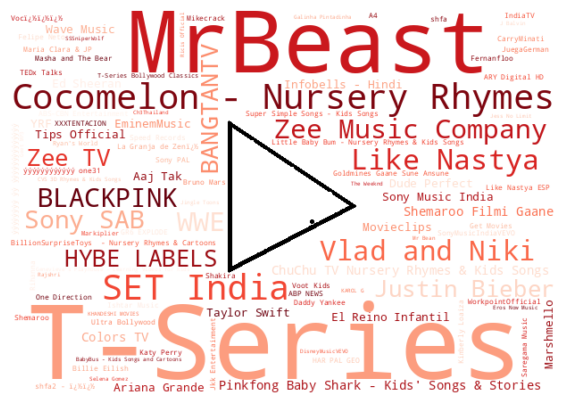

In [ ]:
youtubers_data = dict(zip(df['Youtuber'].tolist(), df['subscribers'].tolist()))

plt.figure(figsize=(30,5))

response = requests.get('https://cached.imagescaler.hbpl.co.uk/resize/scaleWidth/952/cached.offlinehbpl.hbpl.co.uk/news/ORP/YouTube-icon-full_color-20150527090518393.png')
mask_image = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(width=800,
               height=500,
               max_words=100,
               mask=mask_image,
               colormap='Reds_r',
               contour_color='black',
               contour_width=3,
               background_color='white').generate_from_frequencies(youtubers_data)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
top10_most_subscribed_channels = df[:10]
fig = px.sunburst(
    top10_most_subscribed_channels,
    path=['Youtuber', 'Country'],
    values='subscribers',
    color='subscribers',
    color_continuous_scale='Reds'
)
fig.update_layout(
    title_text='Top 10 Most Subscribed YouTubers',
    uniformtext=dict(minsize=8, mode='hide'))
fig.show()

<mark>T-Series, Mr Beast, Cocomelon - Nursery Rhymes</mark> are top Youtubers who have most subscribers.

<mark>T-Series、Mr Beast、Cocomelon - Nursery Rhymes</mark>は、最も多くの登録者を持つトップのユーチューバーである。

<a id="2.3"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.3. Video Views, Video Uploads and Subscribers </div>

In [ ]:
fig = make_subplots(rows=1, cols=3)

fig.update_layout(title_text='Boxplot of Video Views & Video Uploads & Subscribers',
                  uniformtext_minsize=12,
                  uniformtext_mode='hide')

fig.add_trace(go.Box(y=df['video views'],
                     name='Video Views',
                     boxpoints='outliers',
                     marker_color=color_scheme[6],
                     line_color=color_scheme[3]), row=1, col=1)

fig.add_trace(go.Box(y=df['uploads'],
                     name='Video Uploads',
                     boxpoints='outliers',
                     marker_color=color_scheme[6],
                     line_color=color_scheme[4]), row=1, col=2)

fig.add_trace(go.Box(y=df['subscribers'],
                     name='Subscribers',
                     boxpoints='outliers',
                     marker_color=color_scheme[6],
                     line_color=color_scheme[5]), row=1, col=3)

fig.update_layout(
    template='plotly_white'
)

fig.show()

<a id="2.4"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.4. Yearly Earning </div>

In [ ]:
df['average_yearly_earnings'] = (df['lowest_yearly_earnings'] + df['highest_yearly_earnings']) / 2
df['average_monthly_earnings'] = (df['lowest_monthly_earnings'] + df['highest_monthly_earnings']) / 2

In [ ]:
fig = px.histogram(df, x='average_yearly_earnings', marginal='box',
                   color_discrete_sequence=['darkred'])

fig.update_layout(
    title_text='YouTubers Yearly Earnings',
    template='plotly_white',
    xaxis=dict(
        title='Yearly Earnings',
        titlefont_size=16
    ),
    yaxis=dict(
        title='',
        titlefont_size=16
    ),
)
fig.update_traces(marker_line_color='black',
                  marker_line_width=1,
                  opacity=0.8)
fig.show()

YouTubers are mostly earning <b>1M-2.999M</b> dollars yearly. The most profitable youtuber earns <b>58.75M</b> yearly.

このデータにおけるユーチューバーは年間で主に<b>100万ドルから299.9万ドル</b>を稼いでいる。最も利益の高いユーチューバーは年間<b>5875万ドル</b>を稼いでいる。

<a id="2.4"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.4. Channel Cateogry </div>

In [ ]:
category = df['category'].value_counts().sort_values(ascending=True)

fig = px.pie(values=category.values,
             names=category.index,
             color_discrete_sequence=color_scheme)

fig.update_traces(textposition='inside',
                  textfont_size=10,
                  textinfo='percent+label')

fig.update_layout(title_text="Category Pie Graph",
                  uniformtext_minsize=10,
                  uniformtext_mode='hide',
                  template ='plotly_white')

fig.show()

<mark><b>Entertainment, Music, People and Blogs</b></mark> are top3 most used categories among profitable youtubers.

エンターテイメント、音楽、人々とブログは、収益性の高いユーチューバーの中で最も使用されているトップ3のカテゴリである。

<a id="2.5"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">2.5. Geographical Distribution </div>

In [ ]:
country_counts = df['Country'].value_counts()[:10]
fig = go.Figure(go.Funnel(
    y=country_counts.index,
    x=country_counts.values,
    textinfo='value',
    marker={'color': color_scheme}
))

fig.update_layout(
    title_text='Top 10 Country Distribution',
    template='plotly_white'
)
fig.show()

<mark><b>United States, India, Brazil</b></mark> are top3 countries where profitable youtubers are distributed.


<mark><b>アメリカ合衆国、インド、ブラジル</b></mark>は、収益性の高いユーチューバーが多く分布しているトップ3の国である

<a id="3"></a>
# <div style="text-align: center; background-color: #FF4500; font-family: Times New Roman; color: white; padding: 14px; line-height: 1;border-radius:20px">3. Earning Analysis </div>

<a id="3.1"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">3.1. Video Views, Uploads, Subscribers vs Yearly Earnings </div>

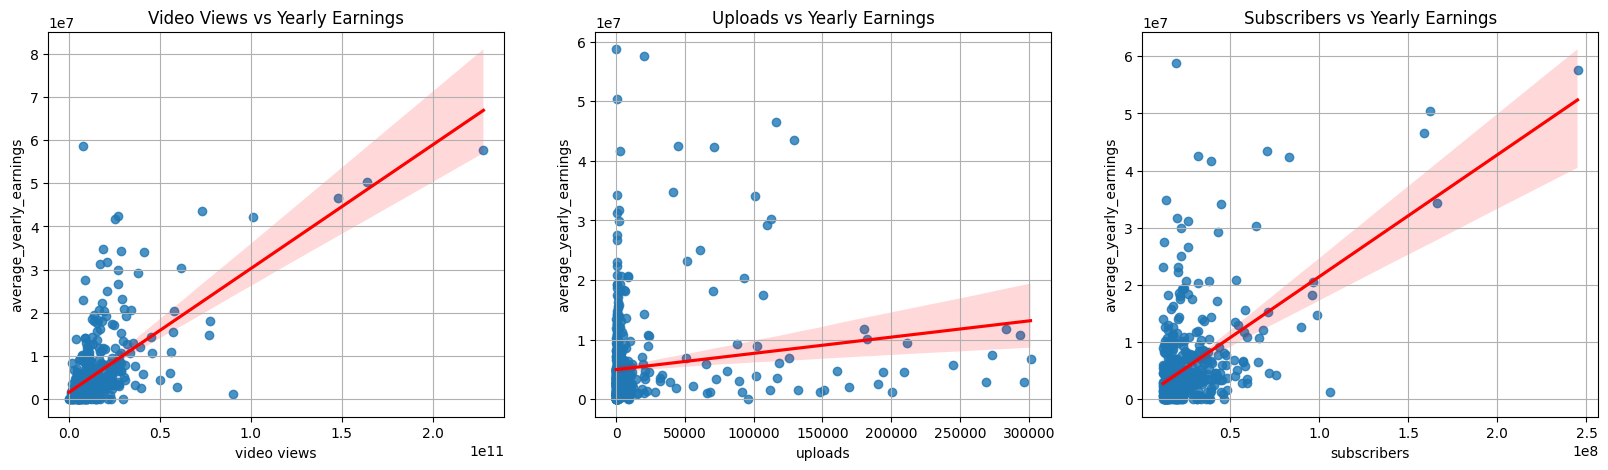

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

sns.regplot(ax=axs[0], data=df, x='video views', y='average_yearly_earnings', line_kws={'color': 'red'})
sns.regplot(ax=axs[1], data=df, x='uploads', y='average_yearly_earnings', line_kws={'color': 'red'})
sns.regplot(ax=axs[2], data=df, x='subscribers', y='average_yearly_earnings', line_kws={'color': 'red'})

axs[0].grid(True)
axs[0].set_title('Video Views vs Yearly Earnings')
axs[1].grid(True)
axs[1].set_title('Uploads vs Yearly Earnings')
axs[2].grid(True)
axs[2].set_title('Subscribers vs Yearly Earnings')
plt.show()

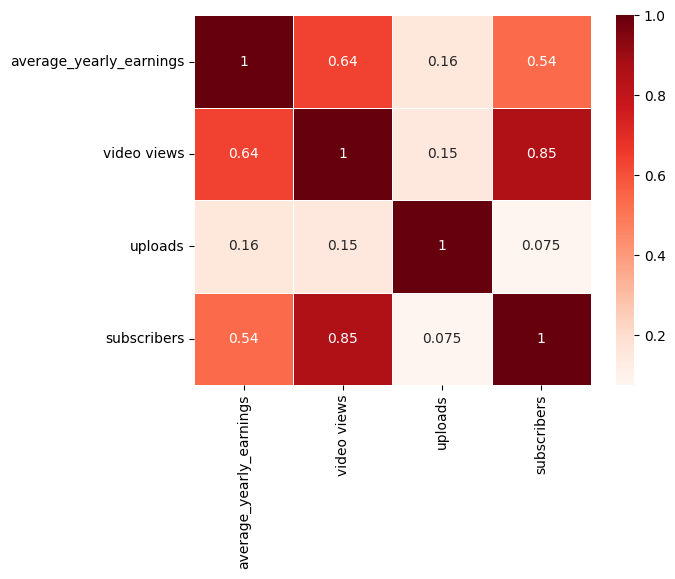

In [ ]:
df_corr = df[['average_yearly_earnings', 'video views', 'uploads', 'subscribers']]
corr = df_corr.corr()
sns.heatmap(corr, annot=True, linewidth=0.5, cmap='Reds')
plt.show()

<mark>Video views</mark> are highly correlated with yearly earnings, and video views have high positive correlation with <mark>subscribers</mark>.

<a id="3.2"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">3.2. Category vs Yearly Earnings </div>

In [ ]:
categories = df.groupby('category')['average_yearly_earnings'].mean().sort_values(ascending=False)

fig = go.Figure(data=px.bar(x=categories.index,
                            y=categories.values,
                            color = categories.index,
                            color_discrete_sequence=color_scheme,
                            title='Average Yearly Earnings by Category',
                            template = 'plotly_white',
                            text = np.round(categories.values/1000000,2),
                            height=500))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color = "black"

fig.update_layout(
    xaxis=dict(
        title='Category',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Average Yearly Earnings',
        titlefont_size=16
    ),
)

fig.show()

In [ ]:
fig = px.scatter(df, x="subscribers", y="average_yearly_earnings",
                 size="average_yearly_earnings", color="category", size_max=60,
                 title="Categories with Video Views and Yearly Earnings",
                 template = 'plotly_white')

lst = [0,1,2,3,4,5,6,7,8]
for idx in lst:
    fig.data[idx].marker.line.width = 5
    fig.data[idx].marker.line.color = 'black'

fig.update_layout(
    xaxis=dict(
        title='Subscribers',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Average Yearly Earnings',
        titlefont_size=16
    ),
)

fig.show()

<mark><b>Shows</b></mark> have the highest average yearly earnings.

<a id="3.3"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">3.3. Geographical Distribution vs Yearly Earnings </div>

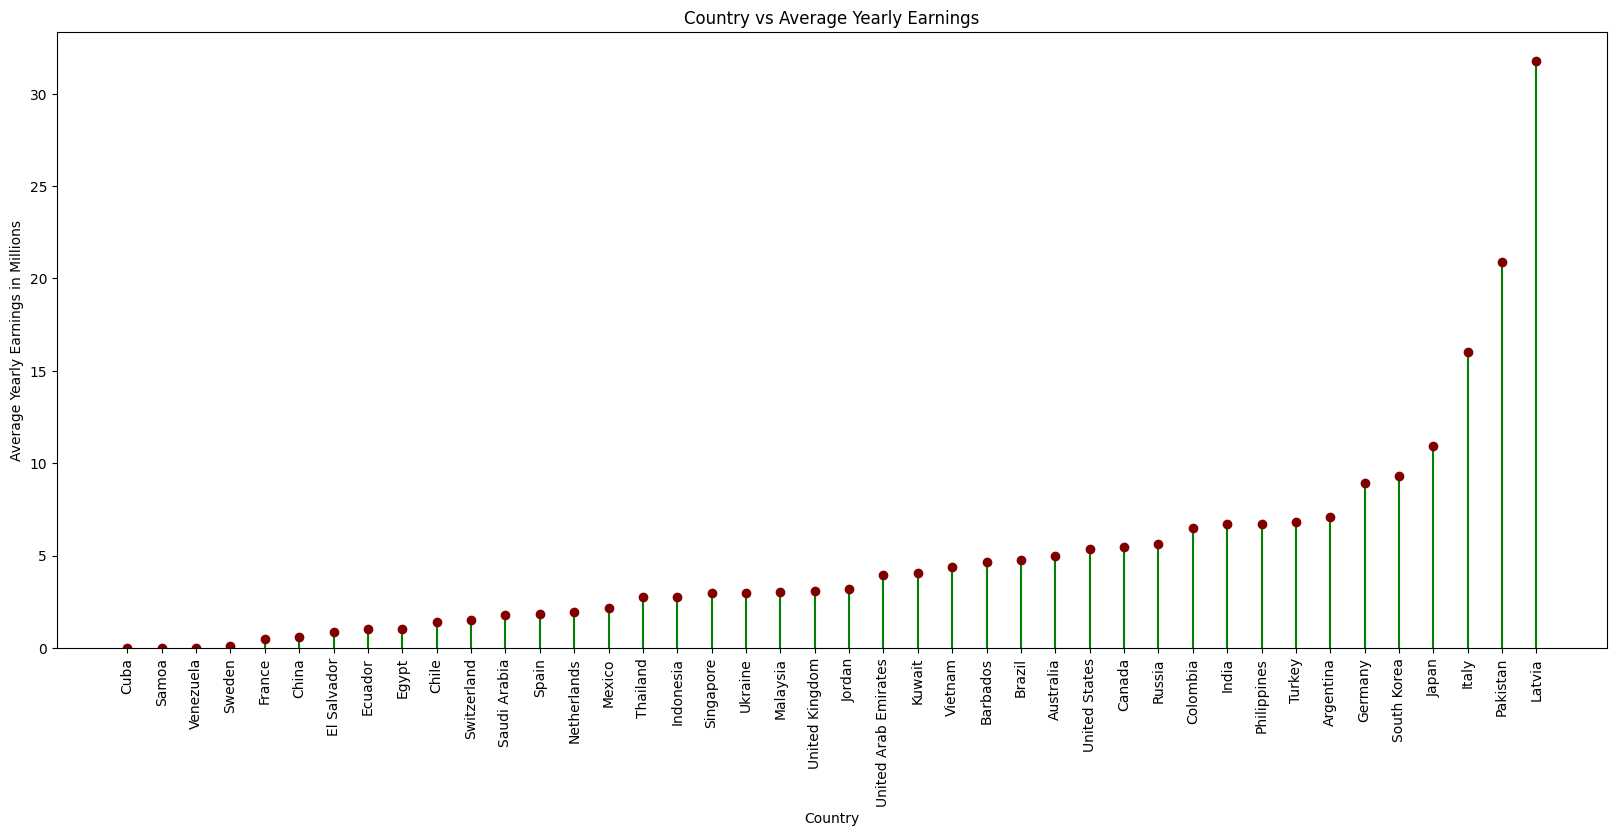

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

country_avg_earnings = df.groupby('Country')['average_yearly_earnings'].mean().sort_values(ascending=True)

x = country_avg_earnings.index.tolist()
y = np.divide(country_avg_earnings.values.tolist(), 1000000)
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.set_ylim(0)
ax.plot(x, y, 'o', color='maroon')
ax.set_xticklabels(x, rotation=90)
ax.set_xlabel('Country')
ax.set_ylabel("Average Yearly Earnings in Millions")
ax.set_title("Country vs Average Yearly Earnings")
plt.show()

YouTube channel published in <mark><b>Latvia</b></mark> has the highest yearly average earnings.

<a id="3.4"></a>
##  <div style="text-align: left; background-color: #F75D59; font-family: Times New Roman; color: white; padding: 6px; line-height: 1;border-radius:10px">3.4. Top 3 Most Earning Countries in Each Category </div>

In [ ]:
cat_lst = df['category'].unique().tolist()
def extract_top3_countries(df):
    frames = []
    for cat in cat_lst:
        cat_df = df.loc[df['category'] == cat]
        top3_country = cat_df.groupby('Country')['average_yearly_earnings'].mean()[:3].index.tolist()
        cat_df = cat_df.loc[df['Country'].isin(top3_country)]
        frames.append(cat_df)
    new_df = pd.concat(frames)
    return new_df

In [ ]:
country_cat_df = extract_top3_countries(df)
fig = px.treemap(country_cat_df, path=['category', 'Country'], color='Country', color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_layout(
    title_text='Top 3 Most Earning Countries in Respective Category')
fig.show()

From the treemap, we can easily see that YouTube Channels published in <mark><b>India and Brazil</b></mark> have high earnings in each cateogry.